## As part of our research, we were able to collect a recent bus stop dataset from LA Metro. I created maps to indicate which bus stop has shade and which does not

In [22]:
# Importing the libraries
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import contextily as ctx
import os
import folium
from folium.features import DivIcon
from branca.element import Template, MacroElement

In [23]:
# Defining the File Path for Metro's Bus Stop Data
file_path = 'Metro_BusStops_CityofLA.shp' 

In [24]:
# Reading the File 
gdf = gpd.read_file(file_path)

In [25]:
# Checking things out
print(gdf.head())

   Join_Count  TARGET_FID  Join_Cou_1  TARGET_F_1    F_        lat  \
0           1           1           1           0   4.0  34.050755   
1           1           2           1           1   6.0  34.050622   
2           1           3           1           2  16.0  34.051763   
3           1           4           1           3  19.0  34.052020   
4           1           5           1           4  20.0  34.052020   

          lng                                  uuid shelter_pr  Shelter  \
0 -118.241121  5b690223-c44e-4055-e89c-524e97851b5d        Yes        1   
1 -118.240582  13347bdd-bb79-4414-9334-b3948b2ad0b6         No        0   
2 -118.242715  cb0990ec-6d9f-481b-ea6a-9c2038f7f745         No        0   
3 -118.243174  5c112356-3d9a-4f94-d86b-8139e39dd903         No        0   
4 -118.243174  5c112356-3d9a-4f94-d86b-8139e39dd903         No        0   

   CountStop  OBJECTID_1 DISTRICT  SB535  RASTERVALU  \
0          1           2        1      0    101.4750   
1          1    

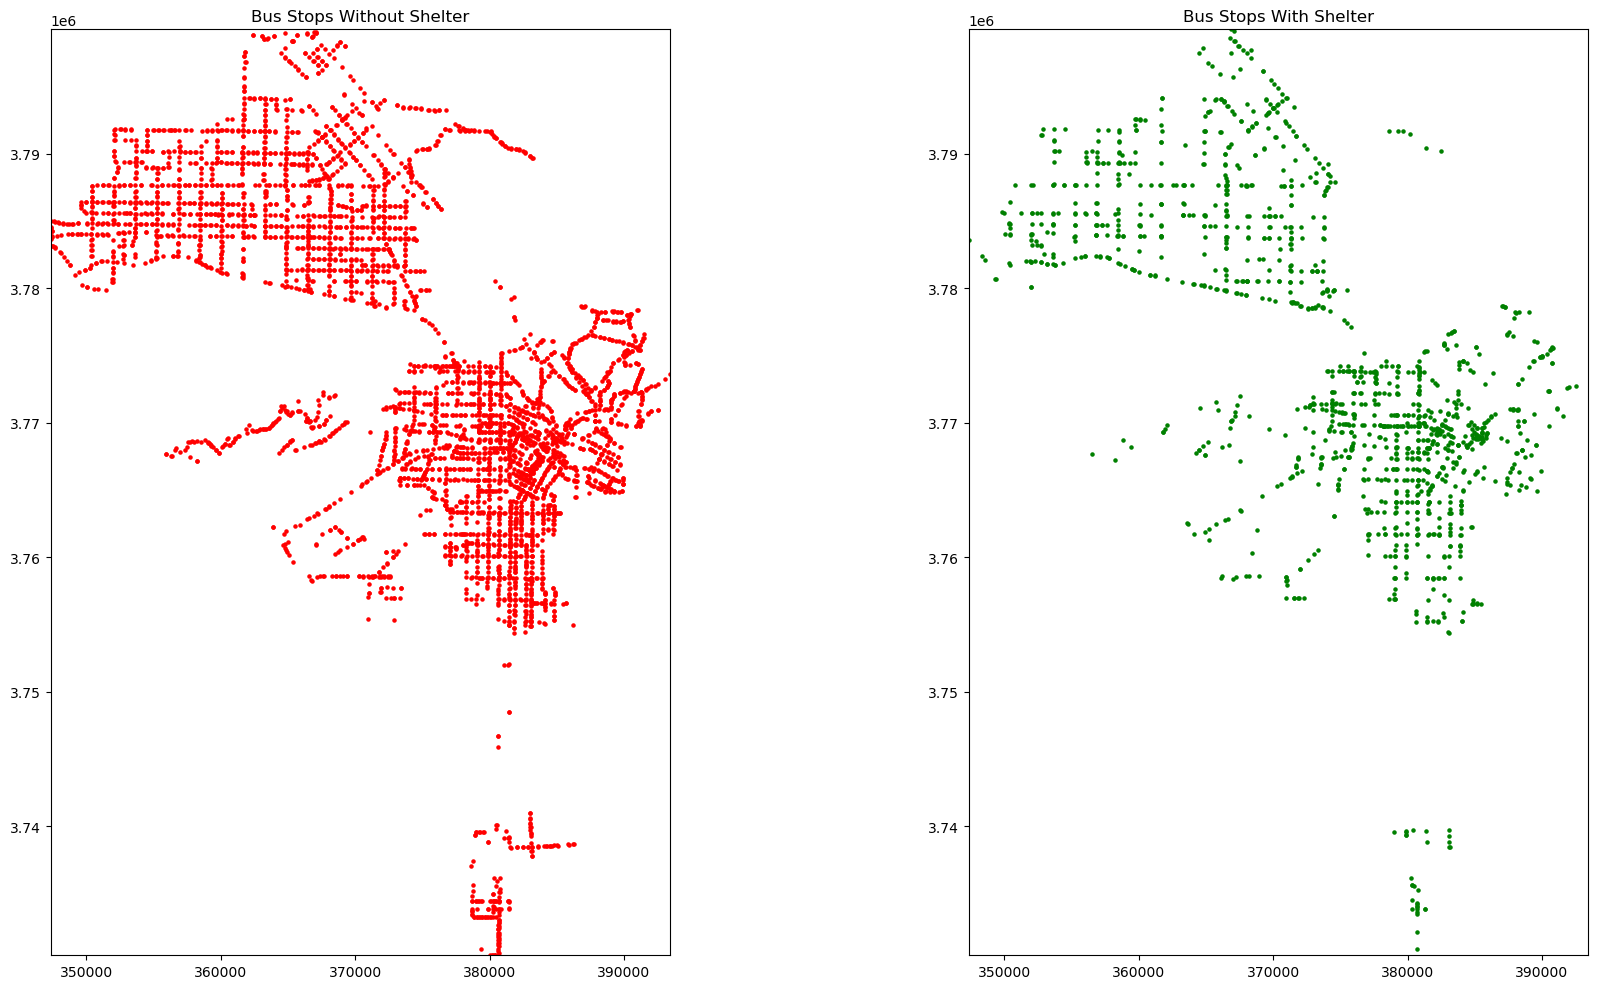

In [26]:
# Creating a figure and two subplots side by side of the entire dataset, sharing the same y-axis, with a size of 20x10 inches
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Retrieving the minimum and maximum bounds of the geodataframe for setting plot limits
bounds = gdf.total_bounds  # returns (minx, miny, maxx, maxy)

# Setting the limits for the plots based on the bounds
xlim = (bounds[0], bounds[2])
ylim = (bounds[1], bounds[3])

# Filtering and plotting bus stops without shelters in red on the first subplot
no_shelter = gdf[gdf['Shelter'] == 0]
no_shelter.plot(ax=axes[0], color='red', markersize=5)
axes[0].set_title('Bus Stops Without Shelter')
axes[0].set_xlim(xlim)
axes[0].set_ylim(ylim)

# Filtering and plotting bus stops with shelters in green on the second subplot
with_shelter = gdf[gdf['Shelter'] == 1]
with_shelter.plot(ax=axes[1], color='green', markersize=5)
axes[1].set_title('Bus Stops With Shelter')
axes[1].set_xlim(xlim)
axes[1].set_ylim(ylim)

# Adjusting the layout of the plots to fit the figure area nicely (given the data)
plt.tight_layout()

# Display
plt.show()

In [27]:
# Reading the neighborhood boundaries
neighborhoods_gdf = gpd.read_file('LA_Times_Neighborhood_Boundaries.geojson')

# Filtering for Silver Lake and Westlake neighborhoods
silver_lake_neighborhood = neighborhoods_gdf[neighborhoods_gdf['name'] == 'Silver Lake']
westlake_neighborhood = neighborhoods_gdf[neighborhoods_gdf['name'] == 'Westlake']

# Reading and defining in the Metro stops data
bus_stops_gdf = gpd.read_file('Metro_BusStops_CityofLA.shp')

# Make sure bus stops are in the same CRS as the neighborhoods
if neighborhoods_gdf.crs:
    bus_stops_gdf = bus_stops_gdf.to_crs(neighborhoods_gdf.crs)
else:
    raise ValueError("The CRS for neighborhoods_gdf is not defined.")
    
# Filtering the GeoDataFrame to include only the bus stops with shelters
gdf_shelter = gdf[gdf['Shelter'] == 1]

# Filtering the GeoDataFrame to include only the bus stops without shelters
gdf_no_shelter = gdf[gdf['Shelter'] == 0]

# Changed the CRS of the GeoDataFrame to match that of the neighborhoods GeoDataFrame
gdf = gdf.to_crs(neighborhoods_gdf.crs)

# Apply the same CRS transformation to the filtered DataFrames
gdf_shelter = gdf_shelter.to_crs(neighborhoods_gdf.crs)
gdf_no_shelter = gdf_no_shelter.to_crs(neighborhoods_gdf.crs)

# Creating the inner spatial join between the bus stops and neighborhoods GeoDataFrames based on their geometries -- this will associate each bus stop with a neighborhood only if they intersect
gdf = gpd.sjoin(gdf, neighborhoods_gdf, how="inner", predicate='intersects')



In [28]:
# Defining neighborhoods
westlake = neighborhoods_gdf[neighborhoods_gdf['name'] == 'Westlake']
silverlake = neighborhoods_gdf[neighborhoods_gdf['name'] == 'Silver Lake']

# Spatial join to associate bus stops with neighborhoods
stops_with_neighborhoods = gpd.sjoin(bus_stops_gdf, neighborhoods_gdf, how="left", predicate='intersects')

# Removing any empty or invalid geometries
silverlake = silverlake[~silverlake.is_empty & silverlake.is_valid]
westlake = westlake[~westlake.is_empty & westlake.is_valid]

# Filtering bus stops for each neighborhood
silverlake_stops = stops_with_neighborhoods[stops_with_neighborhoods['name'] == 'Silver Lake']
westlake_stops = stops_with_neighborhoods[stops_with_neighborhoods['name'] == 'Westlake']


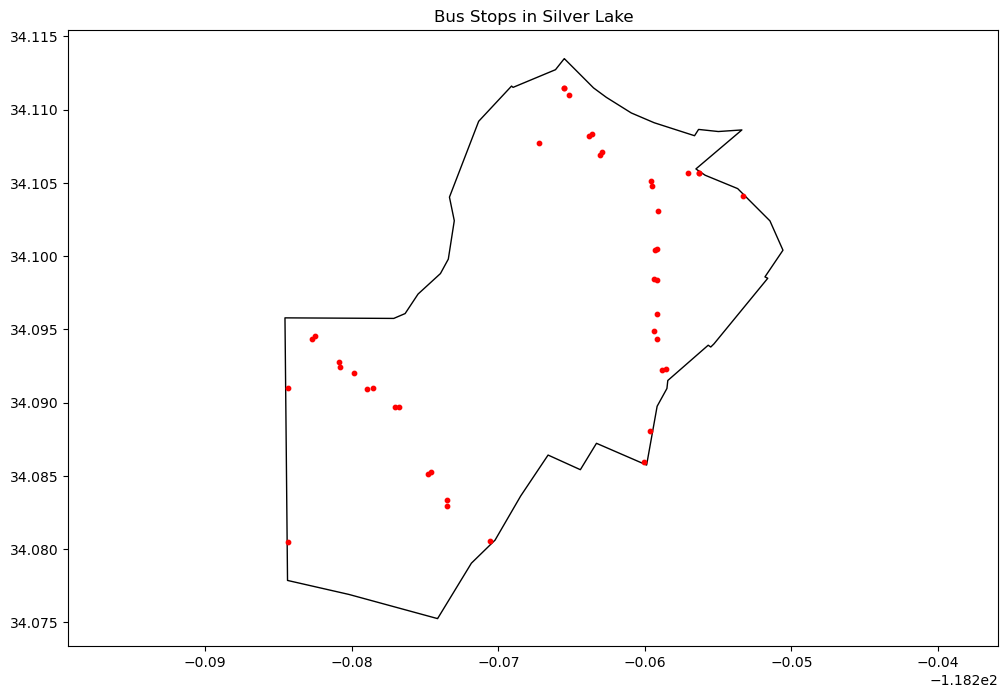

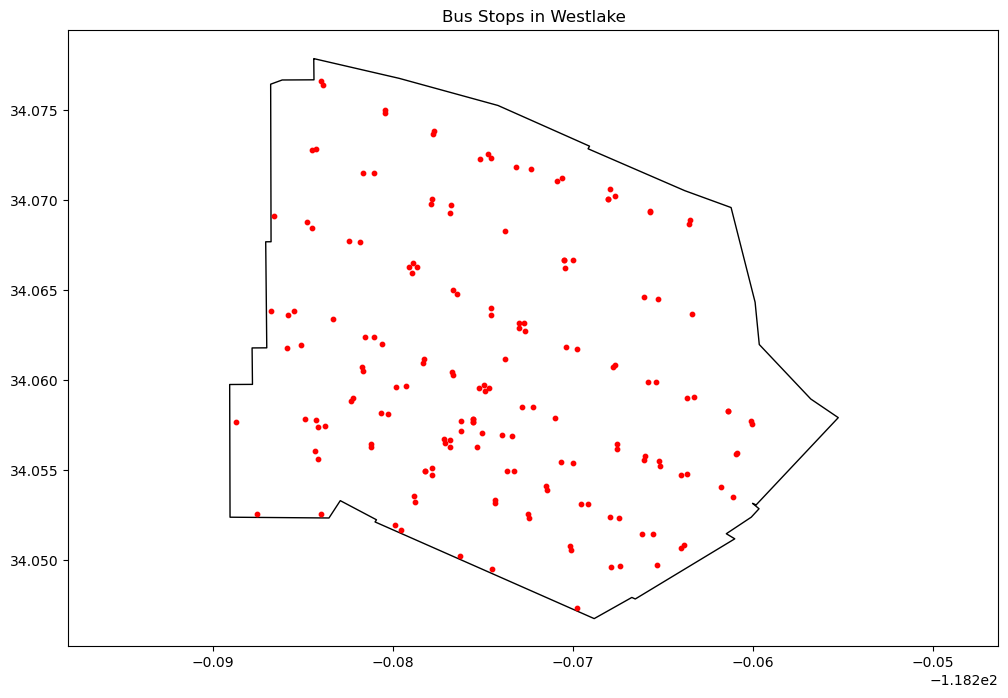

In [29]:
# Plotting the neighborhoods to see all bus stops

def plot_neighborhood_stops(neighborhood_gdf, stops_gdf, title):
    fig, ax = plt.subplots(figsize=(12, 8))
    neighborhood_gdf.plot(ax=ax, color='white', edgecolor='black')
    stops_gdf.plot(ax=ax, color='red', markersize=10)  
    ax.set_title(title)
    plt.axis('equal')
    plt.show()

plot_neighborhood_stops(neighborhoods_gdf[neighborhoods_gdf['name'].isin(['Silver Lake'])], silverlake_stops, 'Bus Stops in Silver Lake')

plot_neighborhood_stops(neighborhoods_gdf[neighborhoods_gdf['name'] == 'Westlake'], westlake_stops, 'Bus Stops in Westlake')



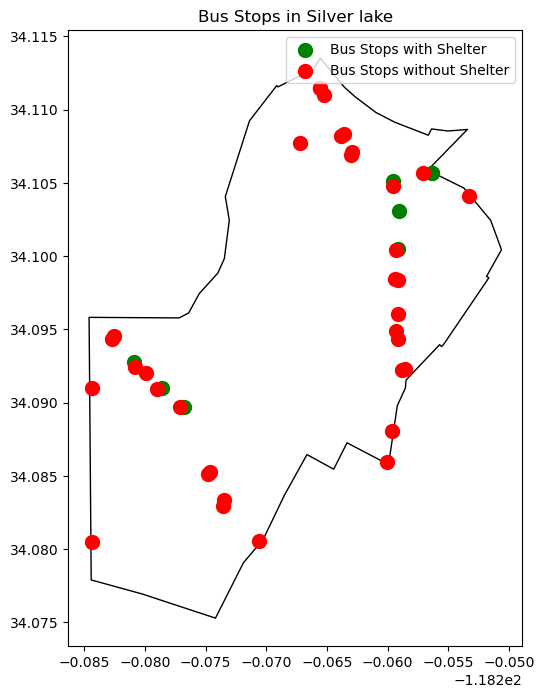

In [32]:
# Filtering out Silver lake with bus stops with and without shelter

fig, ax = plt.subplots(figsize=(12, 8))
silverlake.plot(ax=ax, color='none', edgecolor='black')
silverlake_stops[silverlake_stops['Shelter'] == 1].plot(ax=ax, marker='o', color='green', markersize=100, label='Bus Stops with Shelter')
silverlake_stops[silverlake_stops['Shelter'] == 0].plot(ax=ax, marker='o', color='red', markersize=100, label='Bus Stops without Shelter')
ax.set_title('Bus Stops in Silver lake')
ax.legend()
plt.show()


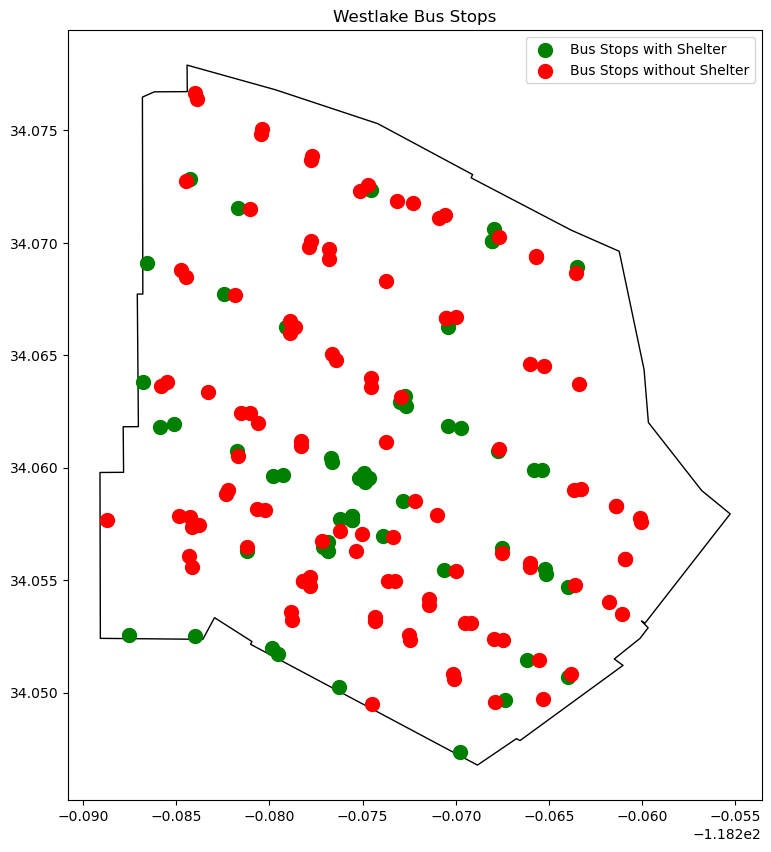

In [33]:
# Filtering out Westlake with bus stops with and without shelt

fig, ax = plt.subplots(figsize=(10, 10))
westlake_neighborhood.plot(ax=ax, color='none', edgecolor='black')
westlake_stops[westlake_stops['Shelter'] == 1].plot(ax=ax, marker='o', color='green', markersize=100, label='Bus Stops with Shelter')
westlake_stops[westlake_stops['Shelter'] == 0].plot(ax=ax, marker='o', color='red', markersize=100, label='Bus Stops without Shelter')
ax.set_title('Westlake Bus Stops')
ax.legend()
plt.show()


In [51]:
# Creating a folium map and aligning the centroid

def create_neighborhood_map(neighborhood, bus_stops, neighborhood_name):
    projected_neighborhood = neighborhood.to_crs(epsg=3857)
    
    centroid_x = projected_neighborhood.geometry.centroid.x.mean()
    centroid_y = projected_neighborhood.geometry.centroid.y.mean()
    
    centroid = gpd.GeoSeries([Point(centroid_x, centroid_y)], crs='EPSG:3857').to_crs(epsg=4326)
    
    m = folium.Map(location=[centroid.geometry.y.iloc[0], centroid.geometry.x.iloc[0]], zoom_start=13.3, tiles='OpenStreetMap')
   
    folium.GeoJson(neighborhood.geometry.to_crs(epsg=4326), name=neighborhood_name).add_to(m)

    m = folium.Map(location=[centroid.geometry.y.iloc[0], centroid.geometry.x.iloc[0]], 
                   zoom_start=14, 
                   tiles='CartoDB positron')
    
    folium.GeoJson(projected_neighborhood.geometry.to_crs(epsg=4326), 
               name=neighborhood_name,
               style_function=lambda x: {'fillColor': 'white', 'color': 'black', 'weight': 0.98}).add_to(m)
  
# Adding markers to the map
    for _, row in bus_stops.iterrows():
        location = [row.geometry.y, row.geometry.x]
        # If the bus stop has a shelter
        if row['Shelter'] == 1:
            folium.CircleMarker(
                location=location,
                radius=5.5,  # for the outer circle
                color='purple',  # purple border for outer circle
                fill=True,
                fill_color='purple',  # purple fill for outer circle
                fill_opacity=0.3
            ).add_to(m)
            folium.CircleMarker(
                location=location,
                radius=3,  # for the inner circle
                color='white',  # white border for inner circle
                fill=True,
                fill_color='white',  # white fill for inner circle
                fill_opacity=0.8
            ).add_to(m)
        else:
            # If the bus stop does not have a shelter
            folium.CircleMarker(
                location=location,
                radius=3,
                color='#76B5BC',  # teel border for circle
                fill=True,
                fill_color='#76B5BC',  # teel fill for circle
                fill_opacity=0.2
            ).add_to(m)

# Creating a header and legend using good ole' HTML
    header_html = """
    <div style="position: fixed; 
                top: 10px; 
                left: 50px; 
                width: 200px; 
                z-index:9999; 
                font-size:24px; 
                background-color: rgba(255, 255, 255, 0.8); 
                padding: 10px; 
                border-radius: 7px;">
    <h2 style="margin:0; padding:0;">Silver Lake</h2>
    </div>
    """
    m.get_root().html.add_child(folium.Element(header_html))


    legend_html = """
    <div style="position: fixed; 
            bottom: 50px; 
            left: 50px; 
            width: 180px; 
            height: auto; 
            background-color: white; 
            border-radius: 5px;
            padding: 10px;
            box-shadow: 0 0 11px rgba(0, 0, 0, 0.2);
            z-index:9999;">
    <b>Bus Stop Legend</b> <br>
    <div style="display: flex; align-items: center; margin-bottom: 4px;">
        <div style='width: 18px; height: 18px; border: 5px solid purple; border-radius: 50%; position: relative;'>
            <div style='width: 8px; height: 8px; background: white; border-radius: 50%; position: absolute; top: 50%; left: 50%; transform: translate(-50%, -50%);'></div>
        </div>
        <span style="margin-left: 5px;">With Shelter</span>
    </div>
    <div style="display: flex; align-items: center; margin-bottom: 4px;">
        <div style='width: 18px; height: 18px; background: #76B5BC; border-radius: 50%;'></div>
        <span style="margin-left: 5px;">Without Shelter</span>
    </div>
    <div style="margin-top: 8px;">
        Total with shelter: 7 <br>
        Total without shelter: 34
    </div>
</div>
"""


    folium.LayerControl().add_to(m)
    
    m.get_root().html.add_child(folium.Element(legend_html))

    return m

silverlake_map = create_neighborhood_map(silverlake, silverlake_stops, 'Silver Lake')

silverlake_map


In [57]:
# Creating a folium map and aligning the centroid

def create_neighborhood_map(neighborhood, bus_stops, neighborhood_name):
    projected_neighborhood = neighborhood.to_crs(epsg=3857)
    
    centroid_x = projected_neighborhood.geometry.centroid.x.mean()
    centroid_y = projected_neighborhood.geometry.centroid.y.mean()
    
    centroid = gpd.GeoSeries([Point(centroid_x, centroid_y)], crs='EPSG:3857').to_crs(epsg=4326)
    
    m = folium.Map(location=[centroid.geometry.y.iloc[0], centroid.geometry.x.iloc[0]], zoom_start=13.3, tiles='OpenStreetMap')
   
    folium.GeoJson(neighborhood.geometry.to_crs(epsg=4326), name=neighborhood_name).add_to(m)

    m = folium.Map(location=[centroid.geometry.y.iloc[0], centroid.geometry.x.iloc[0]], 
                   zoom_start=14, 
                   tiles='CartoDB positron')
    
    folium.GeoJson(projected_neighborhood.geometry.to_crs(epsg=4326), 
               name=neighborhood_name,
               style_function=lambda x: {'fillColor': 'white', 'color': 'black', 'weight': 0.98}).add_to(m)
  
    # Adding markers to the map
    for _, row in bus_stops.iterrows():
        location = [row.geometry.y, row.geometry.x]
        # If the bus stop has a shelter
        if row['Shelter'] == 1:
            folium.CircleMarker(
                location=location,
                radius=5.5,  # for the outer circle
                color='purple',  # purple border for outer circle
                fill=True,
                fill_color='purple',  # purple fill for outer circle
                fill_opacity=0.3
            ).add_to(m)
            folium.CircleMarker(
                location=location,
                radius=.9,  # for the inner circle
                color='white',  # white border for inner circle
                fill=True,
                fill_color='white',  # white fill for inner circle
                fill_opacity=0.8
            ).add_to(m)
        else:
            # If the bus stop does not have a shelter
            folium.CircleMarker(
                location=location,
                radius=3,
                color='#76B5BC',  # teel border for circle
                fill=True,
                fill_color='#76B5BC',  # teel fill for circle
                fill_opacity=0.2
            ).add_to(m)


    header_html = """
    <div style="position: fixed; 
                top: 10px; 
                left: 50px; 
                width: 200px; 
                z-index:9999; 
                font-size:24px; 
                background-color: rgba(255, 255, 255, 0.8); 
                padding: 10px; 
                border-radius: 7px;">
    <h2 style="margin:0; padding:0;">Westlake</h2>
    </div>
    """
    m.get_root().html.add_child(folium.Element(header_html))


    legend_html = """
    <div style="position: fixed; 
            bottom: 50px; 
            left: 50px; 
            width: 180px; 
            height: auto; 
            background-color: white; 
            border-radius: 5px;
            padding: 10px;
            box-shadow: 0 0 11px rgba(0, 0, 0, 0.2);
            z-index:9999;">
    <b>Bus Stop Legend</b> <br>
    <div style="display: flex; align-items: center; margin-bottom: 4px;">
        <div style='width: 18px; height: 18px; border: 5px solid purple; border-radius: 50%; position: relative;'>
            <div style='width: 8px; height: 8px; background: white; border-radius: 50%; position: absolute; top: 50%; left: 50%; transform: translate(-50%, -50%);'></div>
        </div>
        <span style="margin-left: 5px;">With Shelter</span>
    </div>
    <div style="display: flex; align-items: center; margin-bottom: 4px;">
        <div style='width: 18px; height: 18px; background: #76B5BC; border-radius: 50%;'></div>
        <span style="margin-left: 5px;">Without Shelter</span>
    </div>
    <div style="margin-top: 8px;">
        Total with shelter: 56 <br>
        Total without shelter: 110
    </div>
</div>
"""


    folium.LayerControl().add_to(m)
    
    m.get_root().html.add_child(folium.Element(legend_html))

    return m

westlake_map = create_neighborhood_map(westlake_neighborhood, westlake_stops, 'Westlake')

westlake_map



In [60]:
#Preivously used maps that were called christmasy ha

silver_lake_neighborhood = neighborhoods_gdf[neighborhoods_gdf['name'].isin(['Silver Lake'])]

def create_neighborhood_map(neighborhood, bus_stops, neighborhood_name):
    projected_neighborhood = neighborhood.to_crs(epsg=3857)
    
    centroid_x = projected_neighborhood.geometry.centroid.x.mean()
    centroid_y = projected_neighborhood.geometry.centroid.y.mean()
    
    centroid = gpd.GeoSeries([Point(centroid_x, centroid_y)], crs='EPSG:3857').to_crs(epsg=4326)
    
    m = folium.Map(location=[centroid.geometry.y.iloc[0], centroid.geometry.x.iloc[0]], zoom_start=13.3, tiles='OpenStreetMap')
   
    folium.GeoJson(neighborhood.geometry.to_crs(epsg=4326), name=neighborhood_name).add_to(m)
  
    for _, row in bus_stops.iterrows():
        color = 'green' if row['Shelter'] == 1 else 'red'
        folium.CircleMarker(
            location=(row.geometry.y, row.geometry.x),
            radius=5,
            color=color,
            fill=True,
            fill_color=color,
            popup=f"Shelter: {'Yes' if row['Shelter'] == 1 else 'No'}"
        ).add_to(m)

    header_html = """
    <div style="position: fixed; 
                top: 10px; 
                left: 50px; 
                width: 400px; 
                z-index:9999; 
                font-size:24px; 
                background-color: rgba(255, 255, 255, 0.8); 
                padding: 10px; 
                border-radius: 10px;">
    <h2 style="margin:0; padding:0;">Silver Lake</h2>
    </div>
    """
    m.get_root().html.add_child(folium.Element(header_html))


    legend_html = """
    <div style="position: fixed; 
                bottom: 50px; 
                left: 50px; 
                width: 180px; 
                height: auto; 
                background-color: white; 
                border-radius: 5px;
                padding: 10px;
                box-shadow: 0 0 15px rgba(0, 0, 0, 0.2);
                z-index:9999;">
    <b>Bus Stop Legend</b> <br>
    <i class="fa fa-circle fa-1x" style="color:green"></i> With Shelter <br>
    <i class="fa fa-circle fa-1x" style="color:red"></i> Without Shelter <br>
    Total with shelter: 21 <br>
    Total without shelter: 86
    </div>
    """

    folium.LayerControl().add_to(m)
    
    m.get_root().html.add_child(folium.Element(legend_html))
    
    return m


silverlake_map = create_neighborhood_map(silverlake, silverlake_stops, 'Silver Lake')

silverlake_map



In [61]:
#Same for Westlake

def create_neighborhood_map(neighborhood, bus_stops, neighborhood_name):
    projected_neighborhood = neighborhood.to_crs(epsg=3857)
    
    centroid_x = projected_neighborhood.geometry.centroid.x.mean()
    centroid_y = projected_neighborhood.geometry.centroid.y.mean()
    
    centroid = gpd.GeoSeries([Point(centroid_x, centroid_y)], crs='EPSG:3857').to_crs(epsg=4326)
    
    m = folium.Map(location=[centroid.geometry.y.iloc[0], centroid.geometry.x.iloc[0]], zoom_start=15.2, tiles='OpenStreetMap')
   
    folium.GeoJson(neighborhood.geometry.to_crs(epsg=4326), name=neighborhood_name).add_to(m)
  
    for _, row in bus_stops.iterrows():
        color = 'green' if row['Shelter'] == 1 else 'red'
        folium.CircleMarker(
            location=(row.geometry.y, row.geometry.x),
            radius=5,
            color=color,
            fill=True,
            fill_color=color,
            popup=f"Shelter: {'Yes' if row['Shelter'] == 1 else 'No'}"
        ).add_to(m)

    
    header_html = """
    <div style="position: fixed; 
                top: 10px; 
                left: 50px; 
                width: 310px; 
                z-index:9999; 
                font-size:24px; 
                background-color: rgba(255, 255, 255, 0.8); 
                padding: 10px; 
                border-radius: 10px;">
    <h2 style="margin:0; padding:0;">Westlake, Los Angeles</h2>
    </div>
    """
    m.get_root().html.add_child(folium.Element(header_html))

    legend_html = """
    <div style="position: fixed; 
                bottom: 50px; 
                left: 50px; 
                width: 180px; 
                height: auto; 
                background-color: white; 
                border-radius: 5px;
                padding: 10px;
                box-shadow: 0 0 15px rgba(0, 0, 0, 0.2);
                z-index:9999;">
    <b>Bus Stop Legend</b> <br>
    <i class="fa fa-circle fa-1x" style="color:green"></i> With Shelter <br>
    <i class="fa fa-circle fa-1x" style="color:red"></i> Without Shelter <br>
    Total with shelter: 56 <br>
    Total without shelter: 110
    </div>
    """
    m.get_root().html.add_child(folium.Element(legend_html))
    
    return m

westlake_map = create_neighborhood_map(westlake_neighborhood, westlake_stops, 'Westlake')

westlake_map


In [65]:
# Calculate the count of bus stops with and without shelter for Silver Lake
silverlake_shade_count = silverlake_stops[silverlake_stops['Shelter'] == 1].shape[0]
silverlake_no_shade_count = silverlake_stops[silverlake_stops['Shelter'] == 0].shape[0]

# Calculate the count of bus stops with and without shelter for Westlake
westlake_shade_count = westlake_stops[westlake_stops['Shelter'] == 1].shape[0]
westlake_no_shade_count = westlake_stops[westlake_stops['Shelter'] == 0].shape[0]

print(f"Silver Lake - With Shade: {silverlake_shade_count}, Without Shade: {silverlake_no_shade_count}")
print(f"Westlake - With Shade: {westlake_shade_count}, Without Shade: {westlake_no_shade_count}")


Silver Lake - With Shade: 8, Without Shade: 34
Westlake - With Shade: 56, Without Shade: 110


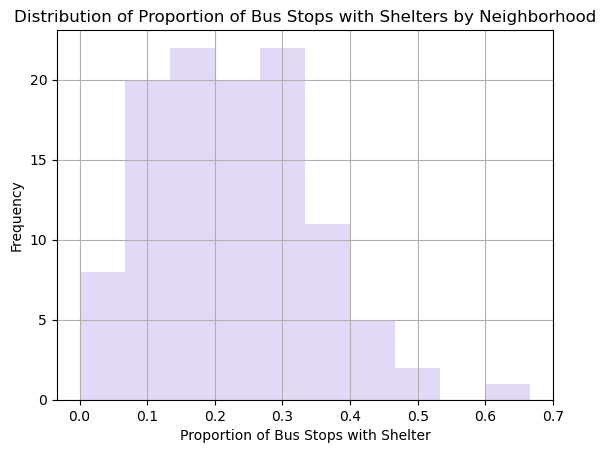

In [68]:
shelters_by_neighborhood = gdf.groupby('name')['Shelter'].mean()

# Now let's plot the distribution
plt.hist(shelters_by_neighborhood, bins=10, alpha=0.7, color='#D6CAF5')
plt.title('Distribution of Proportion of Bus Stops with Shelters by Neighborhood')
plt.xlabel('Proportion of Bus Stops with Shelter')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


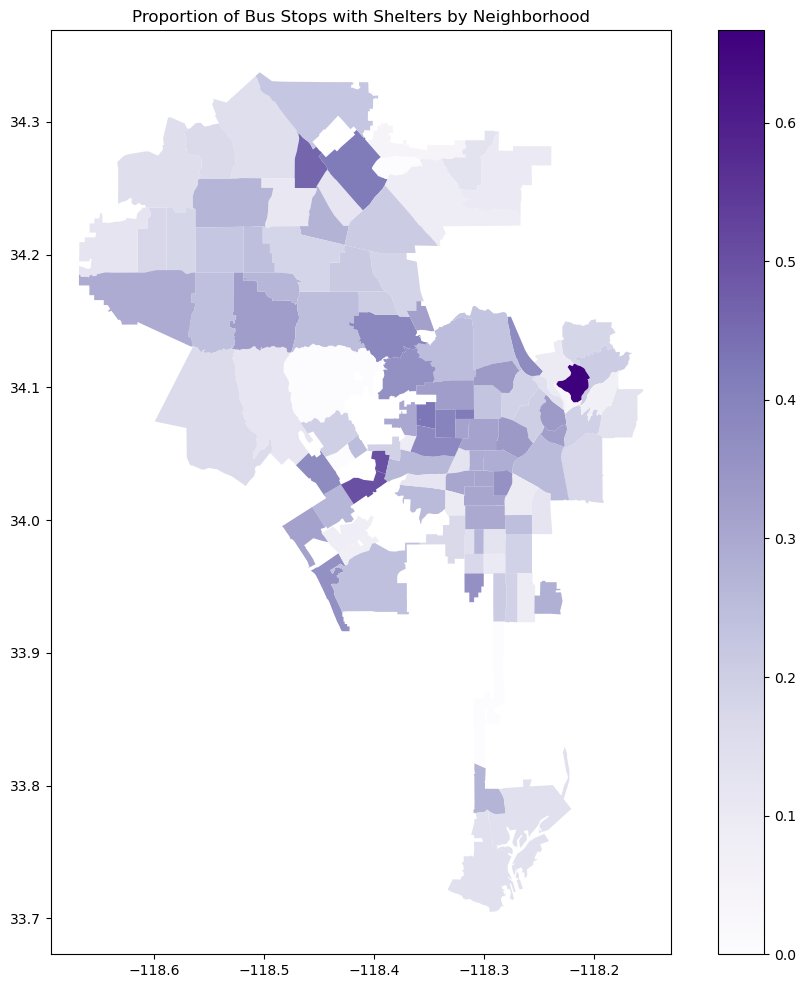

In [74]:
neighborhoods_with_shelter_info = neighborhoods_gdf.merge(shelters_by_neighborhood, how='left', left_on='name', right_index=True)

# Plotting the choropleth map
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
neighborhoods_with_shelter_info.plot(column='Shelter', ax=ax, legend=True, cmap='Purples')
plt.title('Proportion of Bus Stops with Shelters by Neighborhood')
plt.show()


In [79]:
from IPython.display import display, HTML
import folium
from folium.plugins import HeatMap

# Create your map here and assign it to the variable 'm'
# (Your map creation code)

# Create a base map
m = folium.Map(location=[34.0522, -118.2437], zoom_start=10) # LA coordinates

# Adding heat map layer for bus stops with shelters
HeatMap(data=bus_stops_gdf[bus_stops_gdf['Shelter'] == 1][['lat', 'lng']].dropna(), radius=10).add_to(m)

# Display the map with an HTML header
header = '<h3 style="text-align:center">Heatmap of Bus Stops with Shelters in Los Angeles</h3>'
display(HTML(header))
display(m)



In [77]:
# Create a base map
m = folium.Map(location=[34.0522, -118.2437], zoom_start=10)

# Add bus stops with shelters as one color
for idx, row in bus_stops_gdf[bus_stops_gdf['Shelter'] == 1].iterrows():
    folium.CircleMarker(location=[row['lat'], row['lng']], radius=3, color='#D6CAF5').add_to(m)

# Add bus stops without shelters as another color
for idx, row in bus_stops_gdf[bus_stops_gdf['Shelter'] == 0].iterrows():
    folium.CircleMarker(location=[row['lat'], row['lng']], radius=3, color='#9B72AA').add_to(m)  # A darker purple for no shelter

m.save('LA_bus_stops_dot_density.html')



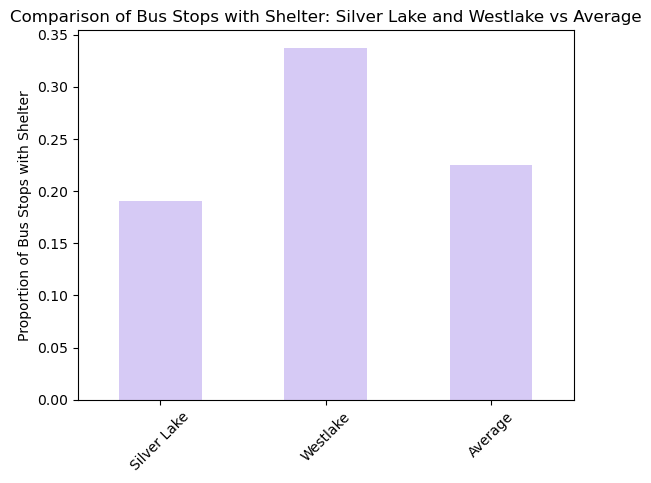

In [84]:
# Doing a statistical analysis to see how Westlake and Silverlake compare to the rest of the dataset

# Neighborhood names as the index and the proportion of shelters as values
selected_neighborhoods = ['Silver Lake', 'Westlake']  # We will compare these two neighborhoods
average_shelters = pd.Series([shelters_by_neighborhood.mean()], index=['Average'])

# Extracting the data for selected neighborhoods and the average
selected_data = shelters_by_neighborhood.loc[selected_neighborhoods]
combined_data = pd.concat([selected_data, average_shelters])

# Creating a bar chart for comparison
colors = ['#D6CAF5' if neighborhood != 'Average' else '#D6CAF5' for neighborhood in combined_data.index]
combined_data.plot(kind='bar', color=colors)
plt.ylabel('Proportion of Bus Stops with Shelter')
plt.title('Comparison of Bus Stops with Shelter: Silver Lake and Westlake vs Average')
plt.xticks(rotation=45)
plt.show()


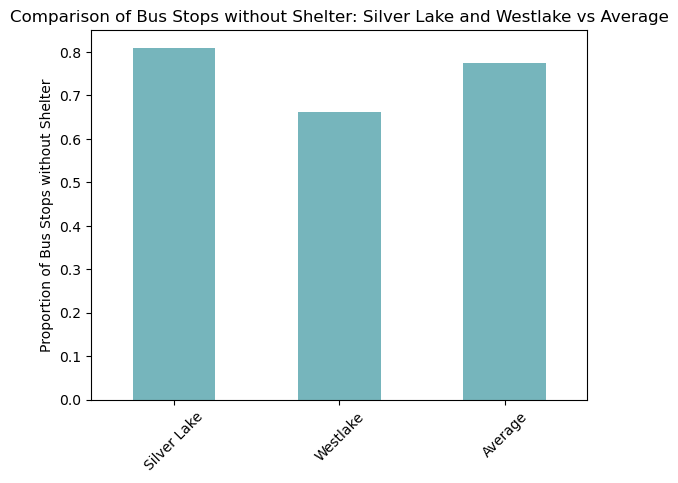

In [86]:
# Now looking at bus stops without shelter
# Neighborhood names as the index and the proportion of shelters as values
# To find the proportion without shelter, we subtract from 1
no_shelters_by_neighborhood = 1 - shelters_by_neighborhood

selected_neighborhoods = ['Silver Lake', 'Westlake']  # We will compare these two neighborhoods
average_no_shelters = pd.Series([no_shelters_by_neighborhood.mean()], index=['Average'])

# Extracting the data for selected neighborhoods and the average
selected_data_no_shelter = no_shelters_by_neighborhood.loc[selected_neighborhoods]
combined_data_no_shelter = pd.concat([selected_data_no_shelter, average_no_shelters])

# Comparison
colors = ['#76B5BC' if neighborhood != 'Average' else '#76B5BC' for neighborhood in combined_data_no_shelter.index]
combined_data_no_shelter.plot(kind='bar', color=colors)
plt.ylabel('Proportion of Bus Stops without Shelter')
plt.title('Comparison of Bus Stops without Shelter: Silver Lake and Westlake vs Average')
plt.xticks(rotation=45)
plt.show()


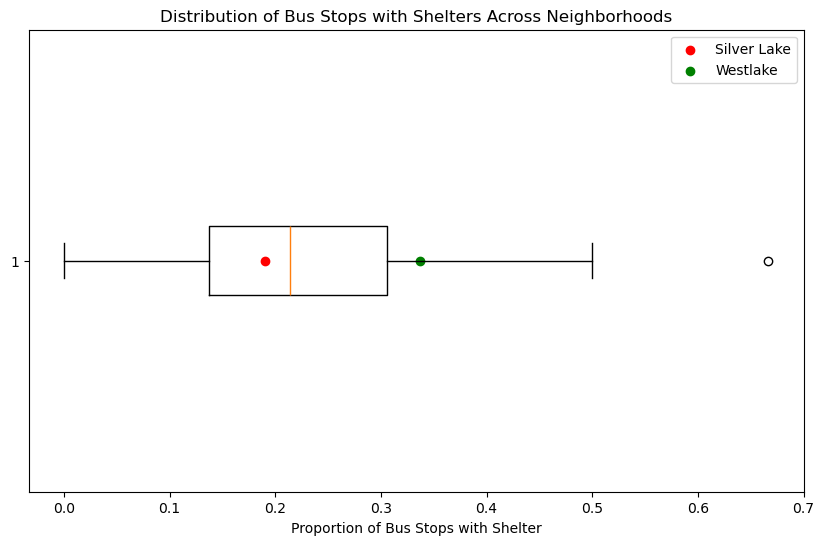

In [87]:
# Assuming 'shelters_by_neighborhood' is a Series as before
plt.figure(figsize=(10, 6))
plt.boxplot(shelters_by_neighborhood, vert=False)
plt.scatter(shelters_by_neighborhood['Silver Lake'], 1, color='r', label='Silver Lake')
plt.scatter(shelters_by_neighborhood['Westlake'], 1, color='g', label='Westlake')
plt.xlabel('Proportion of Bus Stops with Shelter')
plt.title('Distribution of Bus Stops with Shelters Across Neighborhoods')
plt.legend()
plt.show()


In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.ops import nearest_points
import pandas as pd

# Assuming 'bus_stops_gdf' is your GeoDataFrame containing bus stops with shelters and 'neighborhoods_gdf' containing neighborhoods.
# First, calculate the nearest neighbor distance for each bus stop with a shelter.

# Spatial join to get the neighborhood of each bus stop
bus_stops_with_neighborhood = gpd.sjoin(bus_stops_gdf, neighborhoods_gdf, how='left', predicate='intersects')

# Only consider bus stops with shelters
bus_stops_with_shelter = bus_stops_with_neighborhood[bus_stops_with_neighborhood['Shelter'] == 1]

# Define a function to calculate distance to nearest bus stop with shelter
def calculate_nearest(row, other_gdf, this_gdf, value_column):
    """Find the distance to the nearest point and return the distance and value of that point"""
    nearest = other_gdf == nearest_points(row['geometry'], other_gdf.unary_union)[1]
    nearest_value = other_gdf[nearest][value_column].values[0]
    return row.geometry.distance(nearest_value)

# Apply the function to calculate distances
bus_stops_with_shelter['nearest_distance'] = bus_stops_with_shelter.apply(
    calculate_nearest, 
    other_gdf=bus_stops_with_shelter, 
    this_gdf=bus_stops_with_shelter, 
    value_column='geometry', 
    axis=1)

# Now, aggregate these distances by neighborhood
average_distance_by_neighborhood = bus_stops_with_shelter.groupby('name')['nearest_distance'].mean()

# Calculate the overall average distance for comparison
overall_average_distance = bus_stops_with_shelter['nearest_distance'].mean()

# Get the average distance for Silver Lake and Westlake
silver_lake_average = average_distance_by_neighborhood['Silver Lake']
westlake_average = average_distance

plt.bar(['Silver Lake', 'Westlake', 'Overall Average'], 
        [silver_lake_average, westlake_average, overall_average_distance], 
        color=['#D6CAF5', '#76B5BC', 'grey'])

plt.ylabel('Average Distance to Nearest Bus Stop with Shelter')
plt.title('Comparison of Average Distance to Nearest Bus Stop with Shelter')
plt.show()


In [139]:

# Reloading these as jupyter keeps crashing!
neighborhoods_gdf = gpd.read_file('LA_Times_Neighborhood_Boundaries.geojson')
bus_stops_gdf = gpd.read_file('Metro_BusStops_CityofLA.shp')

# Making sure bus stops are in the same CRS as the neighborhoods again
bus_stops_gdf = bus_stops_gdf.to_crs(neighborhoods_gdf.crs)

# Spatial join to associate bus stops with neighborhoods again
stops_with_neighborhoods = gpd.sjoin(bus_stops_gdf, neighborhoods_gdf, how="inner", predicate='intersects')

# Count total bus stops in each neighborhood
total_stops = stops_with_neighborhoods.groupby('name').size().rename('total_bus_stops')

# Joining this with neighborhoods GeoDataFrame
neighborhoods_gdf = neighborhoods_gdf.merge(total_stops, on='name', how='left')

# Counting bus stops with shelters in each neighborhood
shelter_counts = stops_with_neighborhoods[stops_with_neighborhoods['Shelter'] == 1].groupby('name').size().rename('shelter_count')

# Joining the shelter counts with the neighborhoods GeoDataFrame
neighborhoods_gdf = neighborhoods_gdf.merge(shelter_counts, on='name', how='left')

# Filling NaN values with 0 for neighborhoods without any bus stops
neighborhoods_gdf['total_bus_stops'] = neighborhoods_gdf['total_bus_stops'].fillna(0)
neighborhoods_gdf['shelter_count'] = neighborhoods_gdf['shelter_count'].fillna(0)

# Calculating the proportion of bus stops with shelters
neighborhoods_gdf['shelter_proportion'] = neighborhoods_gdf['shelter_count'] / neighborhoods_gdf['total_bus_stops']

# Replace infinities and NaNs with 0
neighborhoods_gdf['shelter_proportion'].replace([float('inf'), float('nan')], 0, inplace=True)

# Creating a Folium map
m = folium.Map(location=[34.0522, -118.2437], zoom_start=10, tiles='CartoDB positron')

# Choropleth
folium.Choropleth(
    geo_data=neighborhoods_gdf.__geo_interface__,
    name='Choropleth',
    data=neighborhoods_gdf,
    columns=['name', 'shelter_proportion'],
    key_on='feature.properties.name',
    fill_color='YlGnBu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Proportion of Bus Stops with Shelters'
).add_to(m)

# Add tooltips
folium.GeoJson(
    neighborhoods_gdf,
    name='Labels',
    style_function=lambda x: {'fillColor': 'transparent', 'color': 'transparent'},
    tooltip=folium.features.GeoJsonTooltip(
        fields=['name', 'shelter_proportion'],
        aliases=['Neighborhood: ', 'Shelters: '],
        localize=True
    )
).add_to(m)

m.add_child(folium.LayerControl())

m.save('sheltered_bus_stops_map.html')


m



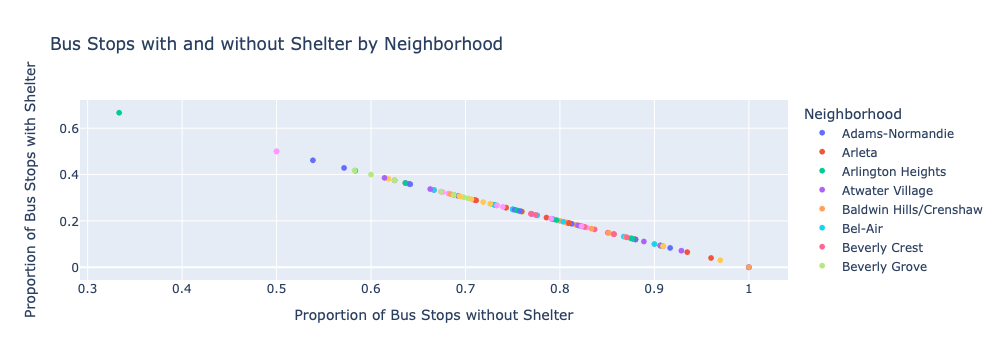

In [143]:
# My colleague and teammate Max provided this code for his portion of the work, 
# I thought it would be great to create a similar one for mean of shelter and without shelter for consistency 

# Analysis of proportion of bus stops with shelter
neighborhoods_gdf['shelter_proportion'] = neighborhoods_gdf['shelter_count'] / neighborhoods_gdf['total_bus_stops']

# Analysis proportion of bus stops without shelter by subtracting from 1
neighborhoods_gdf['no_shelter_proportion'] = 1 - neighborhoods_gdf['shelter_proportion']

# Converting the relevant columns to a Pandas DataFrame for plotting
neighborhood_summary = neighborhoods_gdf[['name', 'shelter_proportion', 'no_shelter_proportion']].copy()

# Renaming the columns for clarity in the plot
neighborhood_summary.rename(columns={
    'shelter_proportion': 'Mean_Shelter',
    'no_shelter_proportion': 'Mean_No_Shelter',
    'name': 'Neighborhood'
}, inplace=True)

# Drop any rows with NaN values that may cause issues in the plot
neighborhood_summary.dropna(inplace=True)

# Create the scatter plot with Plotly Express
fig = px.scatter(neighborhood_summary, x="Mean_No_Shelter", y="Mean_Shelter", color="Neighborhood",
                 labels={
                     "Mean_No_Shelter": "Proportion of Bus Stops without Shelter",
                     "Mean_Shelter": "Proportion of Bus Stops with Shelter"
                 },
                 title="Bus Stops with and without Shelter by Neighborhood")


fig.show()

# HTML file
fig.write_html("bus_stops_shelter_scatter.html")

